# COVID-19 Detection Using Multi-Phase Training of ConvNets with Multi-Class Imbalanced Chest CT Scan Data

The main sections of the notebook are:

1. [Import Needed Libraries](#a)
2. [Logistic Regression](#b)
3. [Training with smotesampled Data](#c)
4. [Two-Phase Training with Undersampling](#d)
5. [Multi-Phase Training with Undersampling](#e)

<div style="text-align: right"> Ahmet Talha Yiğit / 507191101 </div>

<a id=’a’></a>
### 1. Import Needed Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder

from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,classification_report
from sklearn.metrics import average_precision_score,PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit,GridSearchCV
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from imblearn.combine import SMOTEENN

# Import needed packages for the model building and stage
#from skimage import io, transform
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils       
from torchvision.utils import make_grid
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

c:\Users\ahmet\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def lift_scorer(target, pred_proba):
    
    df = pd.DataFrame(pred_proba)
    df.columns = ['pred_proba']
    df['target'] = target.values
    df['pred_proba_rank'] = df['pred_proba'].rank(ascending = False).astype(int)
    lift = round(df[df['pred_proba_rank'] <= round(df['pred_proba_rank'].max() * (1/100), 0)]['target'].sum() / df['target'].sum() * 100, 1)

    return lift

In [4]:
X_train = pd.read_pickle('./Data/X_train_preprocessed.pkl')
y_train = pd.read_pickle('./Data/y_train_preprocessed.pkl')
X_val = pd.read_pickle('./Data/X_val_preprocessed.pkl')
y_val = pd.read_pickle('./Data/y_val_preprocessed.pkl')
X_test = pd.read_pickle('./Data/X_test_preprocessed.pkl')
y_test = pd.read_pickle('./Data/y_test_preprocessed.pkl')

In [5]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000,), (7500, 33), (7500,), (7500, 33), (7500,))

In [6]:
X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_val = X_val.reset_index()
y_val = y_val.reset_index()
X_test = X_test.reset_index()
y_test = y_test.reset_index()

X_train['idx'] = 'Train'
y_train['idx'] = 'Train'
X_val['idx'] = 'Val'
y_val['idx'] = 'Val'
X_test['idx'] = 'Test'
y_test['idx'] = 'Test'

X_train['index'] = X_train['index'].astype('str')
y_train['index'] = y_train['index'].astype('str')
X_val['index'] = X_val['index'].astype('str')
y_val['index'] = y_val['index'].astype('str')
X_test['index'] = X_test['index'].astype('str')
y_test['index'] = y_test['index'].astype('str')

X_train['index'] = X_train[["index", "idx"]].apply("-".join, axis=1)
y_train['index'] = y_train[["index", "idx"]].apply("-".join, axis=1)
X_val['index'] = X_val[["index", "idx"]].apply("-".join, axis=1)
y_val['index'] = y_val[["index", "idx"]].apply("-".join, axis=1)
X_test['index'] = X_test[["index", "idx"]].apply("-".join, axis=1)
y_test['index'] = y_test[["index", "idx"]].apply("-".join, axis=1)

X_train = X_train.set_index('index')
y_train = y_train.set_index('index')
X_val = X_val.set_index('index')
y_val = y_val.set_index('index')
X_test = X_test.set_index('index')
y_test = y_test.set_index('index')

X_train = X_train.drop('idx', axis = 1)
y_train = y_train.drop('idx', axis = 1)
X_val = X_val.drop('idx', axis = 1)
y_val = y_val.drop('idx', axis = 1)
X_test = X_test.drop('idx', axis = 1)
y_test = y_test.drop('idx', axis = 1)

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000, 1), (7500, 33), (7500, 1), (7500, 33), (7500, 1))

In [8]:
X_train.head()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,...,Var_27,Var_28,Var_30,Var_31,Var_33,Var_34,Var_36,Var_38,Var_39,Var_41
index,,,,,,,,,,,,,,,,,,,,,
60075-Train,-0.109742,1.134404,-1.009085,-3.644704,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,...,-0.144079,-0.247141,-0.249080,0.240094,-0.396241,-1.289230,-0.039831,-0.345385,-0.233373,-0.006544
27225-Train,-0.109742,0.075986,0.977945,-0.731477,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,...,-0.144079,-0.247141,-0.249080,0.240094,0.533820,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
403-Train,-0.109742,0.075986,0.702450,-0.631123,0.562187,-0.470549,0.480831,0.641715,0.194911,0.634267,...,0.063240,-0.247141,4.014773,0.240094,2.491077,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
27953-Train,-0.109742,-0.408430,0.702450,1.045385,0.613346,-0.470549,0.480831,0.641715,0.194911,0.634267,...,0.063240,-0.247141,-0.249080,0.240094,0.169018,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
74481-Train,-0.109742,-0.408430,0.702450,0.077261,1.008509,1.183906,0.480831,0.641715,0.194911,-1.576622,...,-0.144079,0.475470,-0.249080,0.240094,0.455636,0.640053,-0.039831,-0.345385,-0.233373,-0.006544


<a id=’b’></a>
## 2. ABOD

In [8]:
from pyod.models.abod import ABOD
from sklearn import model_selection

param_grid = {'n_neighbors': [40, 50]}

classifier_base = ABOD(contamination = 0.01, method = 'fast', n_neighbors=30)

X_gridsearch = X_train.append(X_val)
y_gridsearch = y_train.append(y_val)
split_index = [-1 if x in X_train.index else 0 for x in X_gridsearch.index]
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

gridsearch = GridSearchCV(classifier_base, 
                                          param_grid,
                                          scoring='f1', 
                                          cv=pds, 
                                          n_jobs = -1)

gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())

classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_ABOD = pd.DataFrame()
df_ABOD['ratio'] = 0.01
df_ABOD.loc[0,'ratio'] = 0.01
df_ABOD.loc[0,'model'] = 'ABOD_default'
df_ABOD.loc[0,'precision_train'] = precision_score(y_train,y_train_predict)
df_ABOD.loc[0,'recall_train'] = recall_score(y_train,y_train_predict)
df_ABOD.loc[0,'f1score_train'] = f1_score(y_train,y_train_predict)
df_ABOD.loc[0,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_ABOD.loc[0,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_ABOD.loc[0,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_ABOD.loc[0,'precision_val'] = precision_score(y_val,y_val_predict)
df_ABOD.loc[0,'recall_val'] = recall_score(y_val,y_val_predict)
df_ABOD.loc[0,'f1score_val'] = f1_score(y_val,y_val_predict)
df_ABOD.loc[0,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_ABOD.loc[0,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_ABOD.loc[0,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_ABOD.loc[0,'precisio_test'] = precision_score(y_test,y_test_predict)
df_ABOD.loc[0,'recall_test'] = recall_score(y_test,y_test_predict)
df_ABOD.loc[0,'f1score_test'] = f1_score(y_test,y_test_predict)
df_ABOD.loc[0,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_ABOD.loc[0,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_ABOD.loc[0,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Default hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(df_ABOD.loc[0,'f1score_val'],4) )

classifier_base.set_params(**gridsearch.best_params_)
classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_ABOD.loc[1,'ratio'] = 0.01
df_ABOD.loc[1,'model'] = 'ABOD_Tuned'
df_ABOD.loc[1,'precision_train'] = precision_score(y_train,y_train_predict)
df_ABOD.loc[1,'recall_train'] = recall_score(y_train,y_train_predict)
df_ABOD.loc[1,'f1score_train'] = f1_score(y_train,y_train_predict)
df_ABOD.loc[1,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_ABOD.loc[1,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_ABOD.loc[1,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_ABOD.loc[1,'precision_val'] = precision_score(y_val,y_val_predict)
df_ABOD.loc[1,'recall_val'] = recall_score(y_val,y_val_predict)
df_ABOD.loc[1,'f1score_val'] = f1_score(y_val,y_val_predict)
df_ABOD.loc[1,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_ABOD.loc[1,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_ABOD.loc[1,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_ABOD.loc[1,'precisio_test'] = precision_score(y_test,y_test_predict)
df_ABOD.loc[1,'recall_test'] = recall_score(y_test,y_test_predict)
df_ABOD.loc[1,'f1score_test'] = f1_score(y_test,y_test_predict)
df_ABOD.loc[1,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_ABOD.loc[1,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_ABOD.loc[1,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Tuned hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(gridsearch.best_score_,4) )

Default hpyerparameters: <bound method BaseDetector.get_params of ABOD(contamination=0.01, method='fast', n_neighbors=30)>  	| f1-score_val: 0.068
Tuned hpyerparameters: <bound method BaseDetector.get_params of ABOD(contamination=0.01, method='fast', n_neighbors=40)>  	| f1-score_val: 0.0699


In [9]:
df_ABOD

,ratio,model,precision_train,recall_train,f1score_train,rocauc_train,prauc_train,lift_train,precision_val,recall_val,f1score_val,rocauc_val,prauc_val,lift_val,precisio_test,recall_test,f1score_test,rocauc_test,prauc_test,lift_test
0,0.01,ABOD_default,0.090604,0.090000,0.090301,0.638092,0.034228,9.0,0.069444,0.066667,0.068027,0.643710,0.029945,6.7,0.139241,0.146667,0.142857,0.678103,0.059445,13.3
1,0.01,ABOD_Tuned,0.092437,0.091667,0.092050,0.634847,0.038059,9.2,0.073529,0.066667,0.069930,0.647336,0.037573,6.7,0.151899,0.160000,0.155844,0.664936,0.053792,13.3


In [10]:
gridsearch.best_params_

{'n_neighbors': 40}

In [11]:
pd.DataFrame(y_train_predict_proba).to_pickle('./Probas/y_train_predict_proba_ABOD.pkl')
pd.DataFrame(y_val_predict_proba).to_pickle('./Probas/y_val_predict_proba_ABOD.pkl')
pd.DataFrame(y_test_predict_proba).to_pickle('./Probas/y_test_predict_proba_ABOD.pkl')
pd.DataFrame(df_ABOD).to_pickle('./Probas/ABOD_scores.pkl')

<a id=’b’></a>
## 3. PCA

In [23]:
from pyod.models.pca import PCA

param_grid = {'whiten': [True, False],
              'n_components' : [0.3, 0.5, None],
              }

classifier_base = PCA(contamination = 0.01, random_state = 102022)

X_gridsearch = X_train.append(X_val)
y_gridsearch = y_train.append(y_val)
split_index = [-1 if x in X_train.index else 0 for x in X_gridsearch.index]
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

gridsearch = GridSearchCV(classifier_base, 
                                          param_grid,
                                          scoring='f1', 
                                          cv=pds, 
                                          n_jobs = -1)

gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())

classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_PCA = pd.DataFrame()
df_PCA['ratio'] = 0.01
df_PCA.loc[0,'ratio'] = 0.01
df_PCA.loc[0,'model'] = 'IF_default'
df_PCA.loc[0,'precision_train'] = precision_score(y_train,y_train_predict)
df_PCA.loc[0,'recall_train'] = recall_score(y_train,y_train_predict)
df_PCA.loc[0,'f1score_train'] = f1_score(y_train,y_train_predict)
df_PCA.loc[0,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_PCA.loc[0,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_PCA.loc[0,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_PCA.loc[0,'precision_val'] = precision_score(y_val,y_val_predict)
df_PCA.loc[0,'recall_val'] = recall_score(y_val,y_val_predict)
df_PCA.loc[0,'f1score_val'] = f1_score(y_val,y_val_predict)
df_PCA.loc[0,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_PCA.loc[0,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_PCA.loc[0,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_PCA.loc[0,'precisio_test'] = precision_score(y_test,y_test_predict)
df_PCA.loc[0,'recall_test'] = recall_score(y_test,y_test_predict)
df_PCA.loc[0,'f1score_test'] = f1_score(y_test,y_test_predict)
df_PCA.loc[0,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_PCA.loc[0,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_PCA.loc[0,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Default hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(df_PCA.loc[0,'f1score_val'],4) )

classifier_base.set_params(**gridsearch.best_params_)
classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_PCA.loc[1,'ratio'] = 0.01
df_PCA.loc[1,'model'] = 'IF_Tuned'
df_PCA.loc[1,'precision_train'] = precision_score(y_train,y_train_predict)
df_PCA.loc[1,'recall_train'] = recall_score(y_train,y_train_predict)
df_PCA.loc[1,'f1score_train'] = f1_score(y_train,y_train_predict)
df_PCA.loc[1,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_PCA.loc[1,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_PCA.loc[1,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_PCA.loc[1,'precision_val'] = precision_score(y_val,y_val_predict)
df_PCA.loc[1,'recall_val'] = recall_score(y_val,y_val_predict)
df_PCA.loc[1,'f1score_val'] = f1_score(y_val,y_val_predict)
df_PCA.loc[1,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_PCA.loc[1,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_PCA.loc[1,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_PCA.loc[1,'precisio_test'] = precision_score(y_test,y_test_predict)
df_PCA.loc[1,'recall_test'] = recall_score(y_test,y_test_predict)
df_PCA.loc[1,'f1score_test'] = f1_score(y_test,y_test_predict)
df_PCA.loc[1,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_PCA.loc[1,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_PCA.loc[1,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Tuned hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(gridsearch.best_score_,4) )

Default hpyerparameters: <bound method BaseDetector.get_params of PCA(contamination=0.01, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=102022, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)>  	| f1-score_val: 0.1103
Tuned hpyerparameters: <bound method BaseDetector.get_params of PCA(contamination=0.01, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=102022, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=True)>  	| f1-score_val: 0.1103


In [24]:
df_PCA

,ratio,model,precision_train,recall_train,f1score_train,rocauc_train,prauc_train,lift_train,precision_val,recall_val,f1score_val,rocauc_val,prauc_val,lift_val,precisio_test,recall_test,f1score_test,rocauc_test,prauc_test,lift_test
0,0.01,IF_default,0.128333,0.128333,0.128333,0.654383,0.046719,12.8,0.114286,0.106667,0.110345,0.692441,0.043608,10.7,0.157895,0.2,0.176471,0.651978,0.055446,14.7
1,0.01,IF_Tuned,0.128333,0.128333,0.128333,0.654383,0.046719,12.8,0.114286,0.106667,0.110345,0.692441,0.043608,10.7,0.157895,0.2,0.176471,0.651978,0.055446,14.7


In [25]:
gridsearch.best_params_

{'n_components': None, 'whiten': True}

In [30]:
pd.DataFrame(y_train_predict_proba).to_pickle('./Probas/y_train_predict_proba_PCA.pkl')
pd.DataFrame(y_val_predict_proba).to_pickle('./Probas/y_val_predict_proba_PCA.pkl')
pd.DataFrame(y_test_predict_proba).to_pickle('./Probas/y_test_predict_proba_PCA.pkl')
pd.DataFrame(df_PCA).to_pickle('./Probas/PCA_scores.pkl')

<a id=’b’></a>
## 4. KNN

In [37]:
from pyod.models.knn import KNN

param_grid = {'n_neighbors': [10, 25, 50],
              'method': ['largest', 'median'],
              'metric': ['minkowski',  'cosine', 'manhattan']}

classifier_base = KNN(contamination = 0.01)

X_gridsearch = X_train.append(X_val)
y_gridsearch = y_train.append(y_val)
split_index = [-1 if x in X_train.index else 0 for x in X_gridsearch.index]
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

gridsearch = GridSearchCV(classifier_base, 
                                          param_grid,
                                          scoring='f1', 
                                          cv=pds, 
                                          n_jobs = -1)

gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())

classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_KNN = pd.DataFrame()
df_KNN['ratio'] = 0.01
df_KNN.loc[0,'ratio'] = 0.01
df_KNN.loc[0,'model'] = 'IF_default'
df_KNN.loc[0,'precision_train'] = precision_score(y_train,y_train_predict)
df_KNN.loc[0,'recall_train'] = recall_score(y_train,y_train_predict)
df_KNN.loc[0,'f1score_train'] = f1_score(y_train,y_train_predict)
df_KNN.loc[0,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_KNN.loc[0,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_KNN.loc[0,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_KNN.loc[0,'precision_val'] = precision_score(y_val,y_val_predict)
df_KNN.loc[0,'recall_val'] = recall_score(y_val,y_val_predict)
df_KNN.loc[0,'f1score_val'] = f1_score(y_val,y_val_predict)
df_KNN.loc[0,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_KNN.loc[0,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_KNN.loc[0,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_KNN.loc[0,'precisio_test'] = precision_score(y_test,y_test_predict)
df_KNN.loc[0,'recall_test'] = recall_score(y_test,y_test_predict)
df_KNN.loc[0,'f1score_test'] = f1_score(y_test,y_test_predict)
df_KNN.loc[0,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_KNN.loc[0,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_KNN.loc[0,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Default hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(df_KNN.loc[0,'f1score_val'],4) )

classifier_base.set_params(**gridsearch.best_params_)
classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_KNN.loc[1,'ratio'] = 0.01
df_KNN.loc[1,'model'] = 'IF_Tuned'
df_KNN.loc[1,'precision_train'] = precision_score(y_train,y_train_predict)
df_KNN.loc[1,'recall_train'] = recall_score(y_train,y_train_predict)
df_KNN.loc[1,'f1score_train'] = f1_score(y_train,y_train_predict)
df_KNN.loc[1,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_KNN.loc[1,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_KNN.loc[1,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_KNN.loc[1,'precision_val'] = precision_score(y_val,y_val_predict)
df_KNN.loc[1,'recall_val'] = recall_score(y_val,y_val_predict)
df_KNN.loc[1,'f1score_val'] = f1_score(y_val,y_val_predict)
df_KNN.loc[1,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_KNN.loc[1,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_KNN.loc[1,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_KNN.loc[1,'precisio_test'] = precision_score(y_test,y_test_predict)
df_KNN.loc[1,'recall_test'] = recall_score(y_test,y_test_predict)
df_KNN.loc[1,'f1score_test'] = f1_score(y_test,y_test_predict)
df_KNN.loc[1,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_KNN.loc[1,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_KNN.loc[1,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Tuned hpyerparameters:",classifier_base.get_params, " \t| f1-score_val:", round(gridsearch.best_score_,4) )

Default hpyerparameters: <bound method BaseDetector.get_params of KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)>  	| f1-score_val: 0.0699
Tuned hpyerparameters: <bound method BaseDetector.get_params of KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=50, p=2,
  radius=1.0)>  	| f1-score_val: 0.0972


In [38]:
df_KNN

,ratio,model,precision_train,recall_train,f1score_train,rocauc_train,prauc_train,lift_train,precision_val,recall_val,f1score_val,rocauc_val,prauc_val,lift_val,precisio_test,recall_test,f1score_test,rocauc_test,prauc_test,lift_test
0,0.01,IF_default,0.092593,0.083333,0.087719,0.633155,0.038114,9.0,0.073529,0.066667,0.069930,0.647075,0.038653,6.7,0.141026,0.146667,0.143791,0.663925,0.051023,14.7
1,0.01,IF_Tuned,0.109215,0.106667,0.107926,0.644344,0.043505,10.7,0.101449,0.093333,0.097222,0.675532,0.040565,9.3,0.123596,0.146667,0.134146,0.663443,0.053161,14.7


In [39]:
gridsearch.best_params_

{'method': 'largest', 'metric': 'minkowski', 'n_neighbors': 50}

In [41]:
pd.DataFrame(y_train_predict_proba).to_pickle('./Probas/y_train_predict_proba_KNN.pkl')
pd.DataFrame(y_val_predict_proba).to_pickle('./Probas/y_val_predict_proba_KNN.pkl')
pd.DataFrame(y_test_predict_proba).to_pickle('./Probas/y_test_predict_proba_KNN.pkl')
pd.DataFrame(df_KNN).to_pickle('./Probas/KNN_scores.pkl')

<a id=’b’></a>
## 5. Isolation Forest

In [48]:
from pyod.models.iforest import IForest

param_grid = {'n_estimators': [100, 200, 300], 
              'max_features': [5, 10, 15, 25], 
              'bootstrap': [True, False]}

classifier_base = IForest(contamination = 0.01, random_state=102022, behaviour='new')

X_gridsearch = X_train.append(X_val)
y_gridsearch = y_train.append(y_val)
split_index = [-1 if x in X_train.index else 0 for x in X_gridsearch.index]
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

gridsearch = GridSearchCV(classifier_base, 
                                          param_grid,
                                          scoring='f1', 
                                          cv=pds, 
                                          n_jobs = -1)

gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())

classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_IF = pd.DataFrame()
df_IF['ratio'] = 0.01
df_IF.loc[0,'ratio'] = 0.01
df_IF.loc[0,'model'] = 'IF_default'
df_IF.loc[0,'precision_train'] = precision_score(y_train,y_train_predict)
df_IF.loc[0,'recall_train'] = recall_score(y_train,y_train_predict)
df_IF.loc[0,'f1score_train'] = f1_score(y_train,y_train_predict)
df_IF.loc[0,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_IF.loc[0,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_IF.loc[0,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_IF.loc[0,'precision_val'] = precision_score(y_val,y_val_predict)
df_IF.loc[0,'recall_val'] = recall_score(y_val,y_val_predict)
df_IF.loc[0,'f1score_val'] = f1_score(y_val,y_val_predict)
df_IF.loc[0,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_IF.loc[0,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_IF.loc[0,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_IF.loc[0,'precisio_test'] = precision_score(y_test,y_test_predict)
df_IF.loc[0,'recall_test'] = recall_score(y_test,y_test_predict)
df_IF.loc[0,'f1score_test'] = f1_score(y_test,y_test_predict)
df_IF.loc[0,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_IF.loc[0,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_IF.loc[0,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Default hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(df_IF.loc[0,'f1score_val'],4) )

classifier_base.set_params(**gridsearch.best_params_)
classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_IF.loc[1,'ratio'] = 0.01
df_IF.loc[1,'model'] = 'IF_Tuned'
df_IF.loc[1,'precision_train'] = precision_score(y_train,y_train_predict)
df_IF.loc[1,'recall_train'] = recall_score(y_train,y_train_predict)
df_IF.loc[1,'f1score_train'] = f1_score(y_train,y_train_predict)
df_IF.loc[1,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_IF.loc[1,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_IF.loc[1,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_IF.loc[1,'precision_val'] = precision_score(y_val,y_val_predict)
df_IF.loc[1,'recall_val'] = recall_score(y_val,y_val_predict)
df_IF.loc[1,'f1score_val'] = f1_score(y_val,y_val_predict)
df_IF.loc[1,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_IF.loc[1,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_IF.loc[1,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_IF.loc[1,'precisio_test'] = precision_score(y_test,y_test_predict)
df_IF.loc[1,'recall_test'] = recall_score(y_test,y_test_predict)
df_IF.loc[1,'f1score_test'] = f1_score(y_test,y_test_predict)
df_IF.loc[1,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_IF.loc[1,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_IF.loc[1,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Tuned hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(gridsearch.best_score_,4) )

Default hpyerparameters: <bound method BaseDetector.get_params of IForest(behaviour='new', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=102022, verbose=0)>  	| f1-score_val: 0.1119
Tuned hpyerparameters: <bound method BaseDetector.get_params of IForest(behaviour='new', bootstrap=False, contamination=0.01, max_features=10,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=102022,
    verbose=0)>  	| f1-score_val: 0.1304


In [49]:
df_IF

,ratio,model,precision_train,recall_train,f1score_train,rocauc_train,prauc_train,lift_train,precision_val,recall_val,f1score_val,rocauc_val,prauc_val,lift_val,precisio_test,recall_test,f1score_test,rocauc_test,prauc_test,lift_test
0,0.01,IF_default,0.130,0.130,0.130,0.682497,0.057065,13.0,0.117647,0.106667,0.111888,0.695456,0.051870,10.7,0.151899,0.160000,0.155844,0.686976,0.060929,16.0
1,0.01,IF_Tuned,0.135,0.135,0.135,0.668824,0.056508,13.5,0.142857,0.120000,0.130435,0.664742,0.035929,12.0,0.171053,0.173333,0.172185,0.698610,0.065409,17.3


In [50]:
gridsearch.best_params_

{'bootstrap': False, 'max_features': 10, 'n_estimators': 100}

In [51]:
pd.DataFrame(y_train_predict_proba).to_pickle('./Probas/y_train_predict_proba_IF.pkl')
pd.DataFrame(y_val_predict_proba).to_pickle('./Probas/y_val_predict_proba_IF.pkl')
pd.DataFrame(y_test_predict_proba).to_pickle('./Probas/y_test_predict_proba_IF.pkl')
pd.DataFrame(df_IF).to_pickle('./Probas/IF_scores.pkl')

<a id=’b’></a>
## 6. AE

In [51]:
from pyod.models.auto_encoder import AutoEncoder

param_grid = {'hidden_neurons': [[64, 32, 32, 64], [64, 16, 16, 64], [128, 32, 32, 128]],
              'optimizer': ['adam', 'SGD', 'RMSprop'],
              'epochs': [10,  20],
              'batch_size': [16, 32],
              'dropout_rate':[0, 0.2]}

classifier_base = AutoEncoder(contamination = 0.01, random_state = 102022, verbose= 0)

X_gridsearch = X_train.append(X_val)
y_gridsearch = y_train.append(y_val)
split_index = [-1 if x in X_train.index else 0 for x in X_gridsearch.index]
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

gridsearch = GridSearchCV(classifier_base, 
                                          param_grid,
                                          scoring='f1', 
                                          cv=pds)

gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())

classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_AE = pd.DataFrame()
df_AE['ratio'] = 0.01
df_AE.loc[0,'ratio'] = 0.01
df_AE.loc[0,'model'] = 'AE_default'
df_AE.loc[0,'precision_train'] = precision_score(y_train,y_train_predict)
df_AE.loc[0,'recall_train'] = recall_score(y_train,y_train_predict)
df_AE.loc[0,'f1score_train'] = f1_score(y_train,y_train_predict)
df_AE.loc[0,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_AE.loc[0,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_AE.loc[0,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_AE.loc[0,'precision_val'] = precision_score(y_val,y_val_predict)
df_AE.loc[0,'recall_val'] = recall_score(y_val,y_val_predict)
df_AE.loc[0,'f1score_val'] = f1_score(y_val,y_val_predict)
df_AE.loc[0,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_AE.loc[0,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_AE.loc[0,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_AE.loc[0,'precisio_test'] = precision_score(y_test,y_test_predict)
df_AE.loc[0,'recall_test'] = recall_score(y_test,y_test_predict)
df_AE.loc[0,'f1score_test'] = f1_score(y_test,y_test_predict)
df_AE.loc[0,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_AE.loc[0,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_AE.loc[0,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Default hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(df_AE.loc[0,'f1score_val'],4) )

classifier_base.set_params(**gridsearch.best_params_)
classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

df_AE.loc[1,'ratio'] = 0.01
df_AE.loc[1,'model'] = 'AE_Tuned'
df_AE.loc[1,'precision_train'] = precision_score(y_train,y_train_predict)
df_AE.loc[1,'recall_train'] = recall_score(y_train,y_train_predict)
df_AE.loc[1,'f1score_train'] = f1_score(y_train,y_train_predict)
df_AE.loc[1,'rocauc_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
df_AE.loc[1,'prauc_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
df_AE.loc[1,'lift_train'] = lift_scorer(y_train, y_train_predict_proba[:,1])
df_AE.loc[1,'precision_val'] = precision_score(y_val,y_val_predict)
df_AE.loc[1,'recall_val'] = recall_score(y_val,y_val_predict)
df_AE.loc[1,'f1score_val'] = f1_score(y_val,y_val_predict)
df_AE.loc[1,'rocauc_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
df_AE.loc[1,'prauc_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
df_AE.loc[1,'lift_val'] = lift_scorer(y_val, y_val_predict_proba[:,1])
df_AE.loc[1,'precisio_test'] = precision_score(y_test,y_test_predict)
df_AE.loc[1,'recall_test'] = recall_score(y_test,y_test_predict)
df_AE.loc[1,'f1score_test'] = f1_score(y_test,y_test_predict)
df_AE.loc[1,'rocauc_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
df_AE.loc[1,'prauc_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])     
df_AE.loc[1,'lift_test'] = lift_scorer(y_test, y_test_predict_proba[:,1])     

print("Tuned hpyerparameters:", classifier_base.get_params, " \t| f1-score_val:", round(gridsearch.best_score_,4) )

Default hpyerparameters: <bound method BaseDetector.get_params of AutoEncoder(batch_size=32, contamination=0.01, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[64, 32, 32, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000002CA351FC5E0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=102022, validation_size=0.1, verbose=0)>  	| f1-score_val: 0.1096
Tuned hpyerparameters: <bound method BaseDetector.get_params of AutoEncoder(batch_size=16, contamination=0.01, dropout_rate=0, epochs=10,
      hidden_activation='relu', hidden_neurons=[64, 32, 32, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000002CA351FC5E0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=102022, validation_size=0.1, verbose=0)>  	| f1-score_val: 0.1208


In [52]:
df_AE

,ratio,model,precision_train,recall_train,f1score_train,rocauc_train,prauc_train,lift_train,precision_val,recall_val,f1score_val,rocauc_val,prauc_val,lift_val,precisio_test,recall_test,f1score_test,rocauc_test,prauc_test,lift_test
0,0.01,AE_default,0.128333,0.128333,0.128333,0.653744,0.046637,12.8,0.112676,0.106667,0.109589,0.692509,0.043540,10.7,0.157895,0.2,0.176471,0.652247,0.055437,14.7
1,0.01,AE_Tuned,0.128333,0.128333,0.128333,0.653747,0.046634,12.8,0.112676,0.106667,0.109589,0.692574,0.043548,10.7,0.157895,0.2,0.176471,0.652308,0.055432,14.7


In [53]:
gridsearch.best_params_

{'batch_size': 16,
 'dropout_rate': 0,
 'epochs': 10,
 'hidden_neurons': [64, 32, 32, 64],
 'optimizer': 'adam'}

In [54]:
pd.DataFrame(y_train_predict_proba).to_pickle('./Probas/y_train_predict_proba_AE.pkl')
pd.DataFrame(y_val_predict_proba).to_pickle('./Probas/y_val_predict_proba_AE.pkl')
pd.DataFrame(y_test_predict_proba).to_pickle('./Probas/y_test_predict_proba_AE.pkl')
pd.DataFrame(df_AE).to_pickle('./Probas/AE_scores.pkl')

## IF PRAUC

In [9]:

from pyod.models.iforest import IForest

classifier_base = IForest(contamination = 0.01, random_state=102022, behaviour='new', bootstrap = False, max_features = 10, max_samples='auto', n_estimators=100)



classifier_base.fit(X_train)
y_train_predict = classifier_base.predict(X_train)
y_val_predict = classifier_base.predict(X_val)
y_test_predict = classifier_base.predict(X_test)
y_train_predict_proba = classifier_base.predict_proba(X_train)
y_val_predict_proba = classifier_base.predict_proba(X_val)
y_test_predict_proba = classifier_base.predict_proba(X_test)

In [11]:
ds = pd.DataFrame(y_train_predict)
ds.to_pickle('./IF predictions/y_train_predict.pkl')
ds = pd.DataFrame(y_val_predict)
ds.to_pickle('./IF predictions/y_val_predict.pkl')
ds = pd.DataFrame(y_test_predict)
ds.to_pickle('./IF predictions/y_test_predict.pkl')
ds = pd.DataFrame(y_train_predict_proba)
ds.to_pickle('./IF predictions/y_train_predict_proba.pkl')
ds = pd.DataFrame(y_val_predict_proba)
ds.to_pickle('./IF predictions/y_val_predict_proba.pkl')
ds = pd.DataFrame(y_test_predict_proba)
ds.to_pickle('./IF predictions/y_test_predict_proba.pkl')

Plot PR curves of Resampled & Tuned Model:


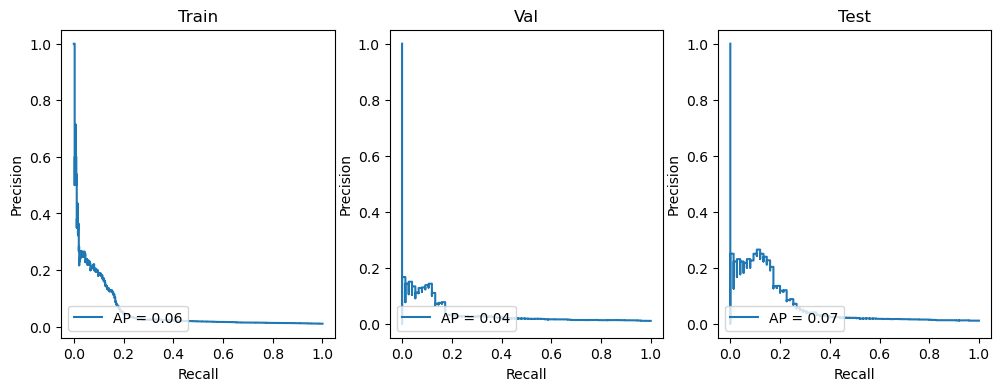

PR_AUC Train: 0.0565 	| PR_AUC Val: 0.0359 	| PR_AUC Test: 0.0654


In [56]:
print('Plot PR curves of Resampled & Tuned Model:')

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_predict_proba[:,1])
AP_train = average_precision_score(y_train, y_train_predict_proba[:,1])
PR_curve_train = PrecisionRecallDisplay(precision_train, recall_train, average_precision = AP_train)
PR_curve_train.plot(ax1)
ax1.set_title("Train")
plt.subplot(1, 3, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_predict_proba[:,1])
AP_val = average_precision_score(y_val, y_val_predict_proba[:,1])
PR_curve_val = PrecisionRecallDisplay(precision_val, recall_val, average_precision = AP_val)
PR_curve_val.plot(ax2)
ax2.set_title("Val")
plt.subplot(1, 3, 3)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_predict_proba[:,1])
AP_test = average_precision_score(y_test, y_test_predict_proba[:,1])
PR_curve_test = PrecisionRecallDisplay(precision_test, recall_test, average_precision = AP_test)
ax3.set_title("Test")
PR_curve_test.plot(ax3)
plt.show()

print('PR_AUC Train:', round(AP_train, 4),'\t| PR_AUC Val:', round(AP_val, 4),'\t| PR_AUC Test:', round(AP_test, 4))